# Sensor-level RSA example on the kiloword EEG dataset

This example demonstrates how to perform representational similarity analysis (RSA) on EEG data, using a searchlight approach.

In the searchlight approach, representational similarity is computed between the model and searchlight "patches". A patch is defined by a seed point (e.g. sensor Pz) and everything within the given radius (e.g. all sensors within 4 cm. of Pz). Patches are created for all possible seed points (e.g. all sensors), so you can think of it as a "searchlight" that moves from seed point to seed point and everything that is in the spotlight is used in the computation.

The radius of a searchlight can be defined in space, in time, or both. In this example, our searchlight will have a spatial radius of 4 cm. and a temporal radius of 0.1 cm.

The dataset will be the kiloword dataset [1]: approximately 1,000 words were presented to 75 participants in a go/no-go lexical decision task while event-related potentials (ERPs) were recorded.

[1] Dufau, S., Grainger, J., Midgley, KJ., Holcomb, PJ. A thousand words are worth a picture: Snapshots of printed-word processing in an event-related potential megastudy. Psychological science, 2015

In [1]:
%load_ext autoreload
%autoreload

In [2]:
import mne
import rsa
import numpy as np
%matplotlib inline

In [3]:
data_path = mne.datasets.kiloword.data_path(verbose=True)
epochs = mne.read_epochs(data_path + '/kword_metadata-epo.fif')
evokeds = [epochs[w].average() for w in epochs.metadata['WORD']]

[............................................................] 100.00% ( 24.3 MB,  16.8 MB/s) /
Verifying hash 3a124170795abbd2e48aae8727e719a8.
Decompressing the archive: /l/vanvlm1/mne_data/MNE-kiloword-data.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/l/vanvlm1/mne_data/MNE-kiloword-data']


In [20]:
model = epochs.metadata.iloc[:, 1:].values  # All word properties
model_dsms = [rsa.compute_dsm(m, metric='sqeuclidean') for m in model]

In [ ]:
evoked_rsa = rsa.rsa_evokeds(evokeds, model_dsm, spatial_radius=1, temporal_radius=0.5, verbose=True, rsa_metric='partial')

In [ ]:
evoked_rsa.plot();

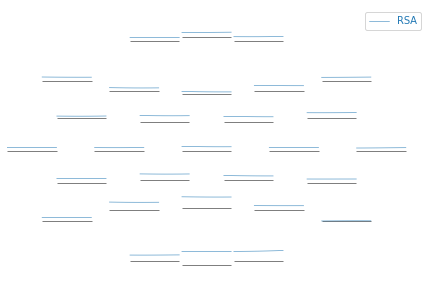

In [18]:
evoked_rsa.plot_topo();

In [ ]:
import gensim

In [ ]:
vecs = gensim.models.KeyedVectors.load_word2vec_format('/m/nbe/project/corpora/englishmodels/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
epochs.metadata.loc[840, 'WORD'] = 'whiskey'  # Alternate spelling
model = vecs[epochs.metadata.WORD]

In [ ]:
import numpy as np
np.save('w2v.npy', model)

In [ ]:
epochs.metadata.query('WORD == "whisky"')